## Deep Reinforcement Learning w tradingu

### Wykorzystywane wskaźniki techniczne

Poniżej znajduje się lista cech (features) wyliczanych w funkcji `load_data()` na podstawie dziennych danych OHLCV. Cechy mają postać kolumn `feature_*` i są następnie standaryzowane kroczącym Z-score (okno 30), aby ograniczyć problem różnych skal i „look-ahead bias”: https://bowtiedraptor.substack.com/p/look-ahead-bias-and-how-to-prevent?open=false#§fixing-this-headache.

---

#### 1. Wskaźniki momentum i oscylatory

- **Relative Strength Index (RSI, 14 dni)**  
  `feature_rsi_14` – klasyczny oscylator momentum, mierzy „siłę” ostatnich wzrostów/spadków.

- **Moving Average Convergence Divergence (MACD, 12/26/9)**  
  Wyliczane są trzy elementy:
  - `feature_macd` – linia MACD  
  - `feature_macd_signal` – linia sygnału  
  - `feature_macd_hist` – histogram (różnica MACD – signal)

---

#### 2. Wskaźniki zmienności i położenia ceny

- **Wstęgi Bollingera (20 dni, ±2σ)**  
  Wyliczane są:
  - `feature_bb_low` – dolna wstęga  
  - `feature_bb_mid` – środkowa wstęga (SMA 20)  
  - `feature_bb_up` – górna wstęga  

- **Znormalizowana pozycja ceny w kanale Bollingera**  
  `feature_close_bb_pos` – pozycja ceny Close względem pasma: $\frac{Close - BB_{mid}}{BB_{up} - BB_{low}}$
  (z małym `1e-12` w mianowniku dla stabilności numerycznej).

- **Dzienne stopy zwrotu**  
  `feature_ret_1d` – procentowa zmiana ceny *Close* dzień do dnia.

- **30-dniowa krocząca zmienność stóp zwrotu**  
  `feature_ret_std_30` – odchylenie standardowe `feature_ret_1d` z okna 30 dni.

---

#### 3. Wskaźniki trendu oparte na średnich kroczących

- **Proste średnie kroczące (SMA)**  
  - `feature_sma_5` – SMA(5)  
  - `feature_sma_20` – SMA(20)

- **Relacja SMA krótkiej do długiej**  
  `feature_sma_5_over_20` – relatywna różnica: $\frac{SMA(5)}{SMA(20)} - 1$

- **Wykładnicze średnie kroczące (EMA)**  
  - `feature_ema_20` – EMA(20)  
  - `feature_ema_50` – EMA(50)

- **Relacja EMA krótkiej do długiej**  
  `feature_ema_20_over_50` – relatywna różnica: $\frac{EMA(20)}{EMA(50)} - 1$

---

#### 4. Dodatkowe miary trendu i zmienności

- **Rate of Change (ROC, 20 dni)**  
  `feature_roc_20` – 20-dniowy momentum liczony jako `pct_change(20)`.

- **Average Directional Index (ADX, 14 dni)**  
  `feature_adx_14` – miara „siły trendu” niezależnie od kierunku.

- **Average True Range (ATR, 14 dni)**  
  - `feature_atr_14` – ATR w jednostkach ceny  
  - `feature_atr_pct` – ATR znormalizowany przez cenę (`ATR / Close`), czyli przybliżona zmienność względna.

- **Rolling Sharpe (20 dni) – jakość krótkookresowego trendu**  
  `feature_sharpe_20` – miara typu „Sharpe w oknie” oparta o średnią i odchylenie `feature_ret_1d` w oknie 20.  
  Uwaga: w kodzie jest to liczona heurystyka (z małym `1e-12` dla stabilności), a nie „książkowy” Sharpe w ujęciu rocznym.

---

#### 5. Skalowanie cech (kroczący Z-score, okno 30)

Po wyliczeniu wskaźników:
1. Usuwane są wiersze z brakami (`dropna()`), które wynikają z okien kroczących.  
2. Zostają wybrane kolumny cech (bez surowych OHLC):  
   `df_scaled_only = df.drop(['Close','High','Open','Low'], axis=1)`  
3. Stosowana jest standaryzacja krocząca `rolling_zscore(..., window=30)`:
   - średnia i odchylenie są liczone w oknie i **przesunięte o 1 dzień** (`shift(1)`), aby nie używać informacji z bieżącej świecy do skalowania bieżącej obserwacji (ograniczenie look-ahead).
4. Na koniec nazwy kolumn i indeksu są zamieniane na lowercase, a kolumny `dividends` i `stock splits` są usuwane.

Wynikiem jest `df_model` z gotowymi cechami wejściowymi do modelu/środowiska.

---

### Wczytywanie danych

Aby stworzyć agenta DQN:

1. wczytujemy do treingu dane o 5 lat poprzedzające próbę testową,
2. zapisujemy dane do pliku typu parquet.

In [12]:
from src.utils import load_data

df_raw_MSFT = load_data('MSFT', '2019-01-01', '2024-05-07')
df_train_MSFT = df_raw_MSFT[df_raw_MSFT.index <= '2023-12-31']
df_test_MSFT = df_raw_MSFT[df_raw_MSFT.index > '2024-01-01']

df_train_MSFT.to_parquet('msft_train.parquet')
df_test_MSFT.to_parquet('msft_test.parquet')

### Rozpoczynamy szkolenie agenta

Szczegółowo trening wykorzystuje:
1.	rl_zoo3.train – moduł z RL-Zoo3 (Stable-Baselines3 Zoo), który uruchamia trening, logowanie, ewaluację i zapisy modeli w ustandaryzowany sposób.

2.	--algo dqn – wybór algorytmu DQN (Deep Q-Network) z biblioteki Stable-Baselines3.

3.	--env TradingEnv – środowisko TradingEnv (z gym-trading-env), w którym agent wykonuje akcje (short/flat/long) i dostaje nagrody na podstawie zmian wartości portfela.

4.	--gym-packages gym_trading_env – informacja dla RL-Zoo3, skąd ma zaimportować/znaleźć środowisko (pakiet Python gym_trading_env).

5.	-conf dqn_tradingenv.yml – plik z hiperparametrami DQN (m.in. learning rate, batch size, gamma, architektura sieci).

6.	-tb runs/msft_dqn – katalog logów TensorBoard, do podglądu metryk uczenia i ewaluacji w TensorBoard.

7.	-f logs/msft_dqn – katalog na logi runu.

8.	--eval-freq 10000 – co 10 000 kroków środowiska uruchamiana jest ewaluacja (test) modelu w osobnym środowisku (tym z --eval-env-kwargs).

9.	--eval-episodes 1 – liczba epizodów w każdej ewaluacji.

10.	--save-freq 100000 – co 100 000 kroków zapisywany jest checkpoint modelu.

11.	--save-replay-buffer – zapis bufora doświadczeń DQN (replay buffer), żeby móc później wznowić trening w podobnym stanie.

12.	--seed 42 – ustawienie ziarna losowości.

13.	--uuid – dodanie unikalnego identyfikatora do nazwy katalogu runu, żeby runy się nie nadpisywały.

14.	--device auto – automatyczny wybór urządzenia.

15.	--vec-env dummy – użycie “DummyVecEnv” (wektoryzacja bez równoległych procesów); stabilne i proste, zwykle najlepsze dla niestandardowych środowisk.

16.	--env-kwargs ... – parametry środowiska treningowego, w tym:
-	df: read_parquet('msft_train.parquet') – dane treningowe,
-	windows:21 – okno obserwacji, które widzi agent,
-	positions:[-1,0,1] – dozwolone pozycje (short/flat/long),
-	trading_fees, borrow_interest_rate – koszty transakcyjne i koszt pożyczki pod short,
-	portfolio_initial_value:10000 – wartość początkowa portfela,
-	max_episode_duration:'max' – epizod trwa maksymalnie długo (zwykle cały zakres danych),
-	disable_env_checker:True – wyłącza checker Gymnasium,
-	verbose:0 – mniej logów z env.
17.	--eval-env-kwargs – analogiczne parametry, ale dla środowiska ewaluacyjnego (tu z msft_test.parquet), dzięki czemu metryki “eval/*” są liczone na osobnym zbiorze testowym, a nie na treningowym.

Biblioteki:
- https://stable-baselines3.readthedocs.io/en/master/
- https://stable-baselines3.readthedocs.io/en/master/guide/rl_zoo.html
- https://gymnasium.farama.org
- https://gym-trading-env.readthedocs.io/en/latest/

---
MODEL JEST WYTRENOWANY, PONIŻSZY KOD SŁUŻY JEDYNIE PREZENTACJI
---

In [13]:
"""
!python -m rl_zoo3.train --algo dqn --env TradingEnv --gym-packages gym_trading_env \ 
  -conf dqn_tradingenv.yml \
  -tb runs/msft_dqn \
  -f logs/msft_dqn \
  --eval-freq 10000 \
  --eval-episodes 1 \
  --save-freq 100000 \
  --save-replay-buffer \
  --seed 42 \
  --uuid \
  --device auto \
  --vec-env dummy \
  --env-kwargs \
  df:"__import__('pandas').read_parquet('msft_train.parquet')" \
  windows:21 \
  positions:"[-1, 0, 1]" \
  initial_position:0 \
  trading_fees:0.0004 \
  borrow_interest_rate:0.0004365079365079365 \
  portfolio_initial_value:10000 \
  max_episode_duration:"'max'" \
  disable_env_checker:True \
  verbose:0 \
  --eval-env-kwargs \
  df:"__import__('pandas').read_parquet('msft_test.parquet')" \
  windows:21 \
  positions:"[-1, 0, 1]" \
  initial_position:0 \
  trading_fees:0.0004 \
  borrow_interest_rate:0.0004365079365079365 \
  portfolio_initial_value:10000 \
  max_episode_duration:"'max'" \
  disable_env_checker:True \
  verbose:0
"""

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/var/folders/7h/5md9hcys1_32sbgcdckg623r0000gn/T/ipykernel_25951/946707551.py:1: SyntaxWarning: invalid escape sequence '\ '
  """


'\n!python -m rl_zoo3.train --algo dqn --env TradingEnv --gym-packages gym_trading_env \\ \n  -conf dqn_tradingenv.yml   -tb runs/msft_dqn   -f logs/msft_dqn   --eval-freq 10000   --eval-episodes 1   --save-freq 100000   --save-replay-buffer   --seed 42   --uuid   --device auto   --vec-env dummy   --env-kwargs   df:"__import__(\'pandas\').read_parquet(\'msft_train.parquet\')"   windows:21   positions:"[-1, 0, 1]"   initial_position:0   trading_fees:0.0004   borrow_interest_rate:0.0004365079365079365   portfolio_initial_value:10000   max_episode_duration:"\'max\'"   disable_env_checker:True   verbose:0   --eval-env-kwargs   df:"__import__(\'pandas\').read_parquet(\'msft_test.parquet\')"   windows:21   positions:"[-1, 0, 1]"   initial_position:0   trading_fees:0.0004   borrow_interest_rate:0.0004365079365079365   portfolio_initial_value:10000   max_episode_duration:"\'max\'"   disable_env_checker:True   verbose:0\n'

### Instrukcja treningu agenta
Aby wytrenować swojego agenta należy odkomentować powyższy kod i uruchomić go, ewentualnie pozmieniać parametry.

Do katalogów runs i logs zapisze się przebieg treningu. 

Obecnie w folderze runs znajdują się katalogi DQN_1 (testowy model) i DQN_2 (lepszy model). Kolejne runy bedą zapisywane pod nazwą DQN_3, DQN_4 etc. 
Pliki w katalogach wykorzystuje tensorboard.

W folderze logs znajdują się katalogi best_model i test_model. Kolejne logi z gotowymi do użycia modelami bedą zapisywane pod długimi i dziwnymi nazwami. 

Edycja hiperparametrów sieci neuronowej odbywa się przez edycję pliku dqn_tradingenv.yml.

Hiperparametry wybrane zostały drogą optymalizacji z wykorzystaniem bilioteki optuna. Szczegóły w pliku eval.ipynb.

---

### Tworzymy środowisko testowe
Ponieważ agent wykorzystuje 21 ostatnich obserwacji do podjęcia decyzji, df_eval_MSFT obejmuje ostatnie 21 dni grudnia, które są potrzebne agentowi do podjęcia decyzji 1 stycznie.

In [14]:
import gymnasium as gym
import pandas as pd
import gym_trading_env

df_eval_MSFT = pd.concat([df_train_MSFT.iloc[-21:], df_test_MSFT])

env_test = gym.make(
        "TradingEnv", # Nazwa środowiska
        name= "MSFT",
        df = df_eval_MSFT, # Dataset
        windows= 21, # Okno obserwacji, które widzi agent
        positions = [-1, 0, 1], # Możliwe akcje agenta (short, flat, long)
        initial_position = 0, # Agent zaczyna w pozycji flat
        trading_fees = 0.04/100, # Koszt zakupu akcji (można dowolnie zmieniać)
        borrow_interest_rate = 0.11 / 252, # Koszt porzyczenia akcji (można dowolnie zmieniać)
        portfolio_initial_value = 10_000, # Wartość portfela początkowego
        max_episode_duration = "max", # Agent przechodzi przez cały zbiór testowy
        disable_env_checker= True,
        verbose=0
    )

### Działanie agenta w środowisku testowym
1. Wczytujemy najlepszy model DQN uzyskany w czasie treningu.
2. Następnie za pomocą funkcji reset() uzyskujemy dane z grudnia, na podstawie których agent podejmie pierwszą akcję.
3. Wrzucamy agenta do środowiska testowego i obserwujemy jak środowisko reaguje na jego akcje.

In [15]:
from stable_baselines3 import DQN
import numpy as np
import matplotlib.pyplot as plt

# Wczytanie modelu
best_model = DQN.load("logs/msft_dqn/dqn/TradingEnv_best_model/best_model.zip") #Można podmienić na swój model

# Tworzymy zmienną obs
obs, _ = env_test.reset()

# Pętla działająca do momentu kiedy dojdziemy do końca okna testowego (6 maja)
while True:
    action, _ = best_model.predict(obs, deterministic=True) # Agent wybiera najlepszą akcję
    obs, reward, done, truncated, info = env_test.step(action) # Przechodzimy do kolejnego dnia wykorzystując akcję agenta
    if done or truncated:
        break

# Wyciągamy przy pomocy unwrapped przebieg eksperymentu
hist = env_test.unwrapped.historical_info

### Ewaluacja agenta
Metryki na podstawie których weryfikujemy pracę agenta to:
- drawdown
- rozkład pozycji
- stopa zwrotu long vs short
- porównanie ze strategią B&H

---
### Drawdown

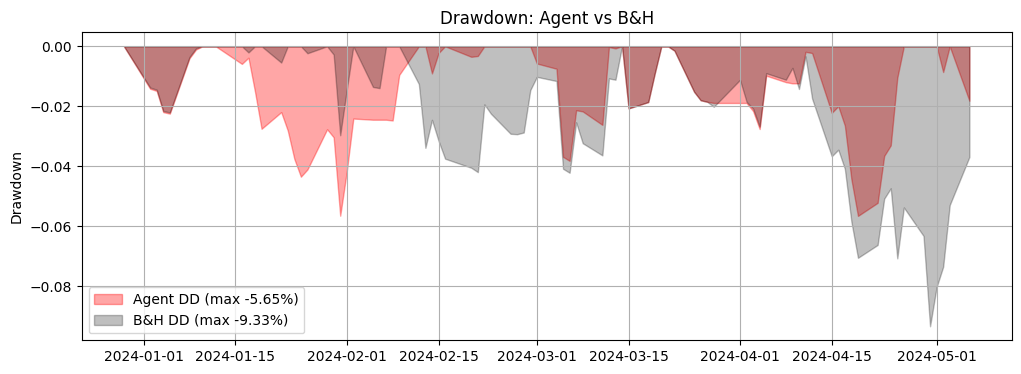

In [16]:
dates = np.asarray(hist["date"], dtype="datetime64[ns]")
portfolio_values = np.asarray(hist["portfolio_valuation"], dtype=np.float64)
positions = np.asarray(hist["position"], dtype=np.float64)
rewards = np.asarray(hist["reward"], dtype=np.float64)

close_series = np.asarray(hist["data_close"], dtype=np.float64)

initial_value = portfolio_values[0]
bh_values = initial_value * (close_series / close_series[0])

# Drawdown
def compute_drawdown(values: np.ndarray):
    cum_max = np.maximum.accumulate(values)
    dd = (values - cum_max) / cum_max
    return dd, dd.min()

dd_agent, max_dd_agent = compute_drawdown(portfolio_values)
dd_bh, max_dd_bh = compute_drawdown(bh_values)

plt.figure(figsize=(12, 4))
plt.fill_between(dates, dd_agent, 0, alpha=0.35, color="red", label=f"Agent DD (max {max_dd_agent:.2%})")
plt.fill_between(dates, dd_bh, 0, alpha=0.25, color="black", label=f"B&H DD (max {max_dd_bh:.2%})")

plt.title("Drawdown: Agent vs B&H")
plt.ylabel("Drawdown")
plt.grid(True)
plt.legend()
plt.show()

### Podsumowanie
Najwyższą wartość wskaźnika osiągnęła strategia B&H (-9,33%).

Agent DQN widocznie lepiej identyfikuje sygnał zmiany trendu co pozwala zmniejszyć drawdown (-5,65%)

---
### Zajmowane pozycje

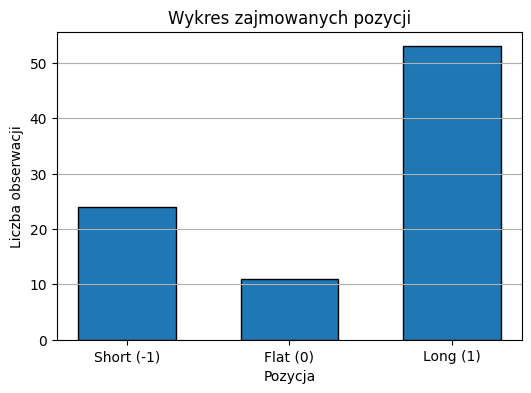

In [17]:
# Rozkład zajmowanych pozycji
values, counts = np.unique(positions, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(values, counts, width=0.6, edgecolor="black")
plt.xticks(values, ["Short (-1)", "Flat (0)", "Long (1)"])
plt.title("Wykres zajmowanych pozycji")
plt.xlabel("Pozycja")
plt.ylabel("Liczba obserwacji")
plt.grid(axis="y")
plt.show()

### Podsumowanie
Agent najczęściej pozostaje w pozycji long.

Drugą najczęściej wybieraną pozycją jest pozycja short.

Najrzadziej agent jest poza rynkiem.

Zróżnicowanie wskazuje na zdolność agenta do dostosowywania pozycji do realiów rynkowych.

---

### Stopy zwrotu w pozycjach

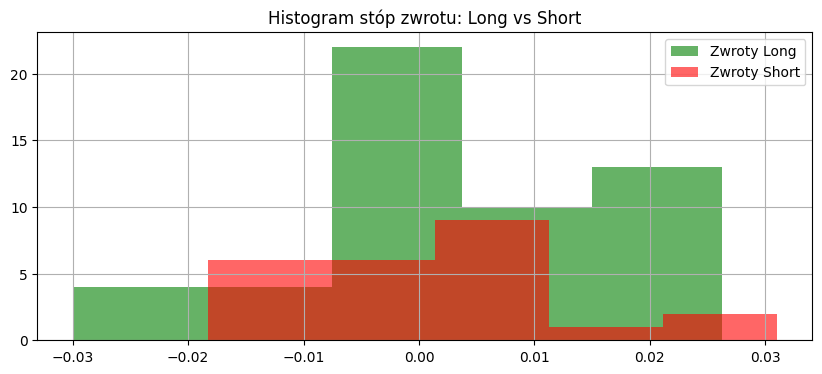

In [18]:
# Zwroty Long vs Short (wyrównanie pozycji z rewardem)
long_rets = rewards[positions > 0]
short_rets = rewards[positions < 0]

plt.figure(figsize=(10,4))
plt.hist(long_rets, bins=5, alpha=0.6, label="Zwroty Long", color='green')
plt.hist(short_rets, bins=5, alpha=0.6, label="Zwroty Short", color='red')
plt.title("Histogram stóp zwrotu: Long vs Short")
plt.legend()
plt.grid(True)
plt.show()

### Posumowanie
Agent decyduje się na short rzadziej, ale straty, które poniósł w shorcie są mniejsze niż w longu

---

### Wartość portfela B&H vs DQN

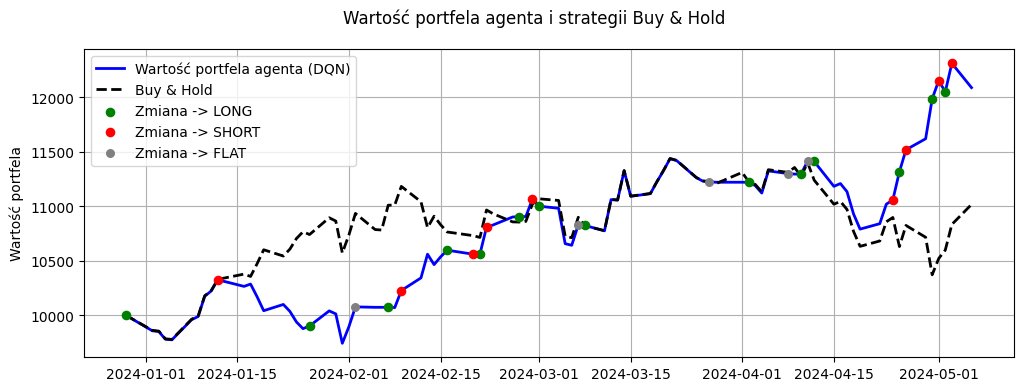

In [19]:
close_series = np.asarray(hist["data_close"], dtype=np.float64)

initial_value = portfolio_values[0]
bh_values = initial_value * (close_series / close_series[0])

pos_prev = positions[:-1]
pos_curr = positions[1:]

change_idx = np.where(pos_curr != pos_prev)[0] + 1

long_entries_idx  = change_idx[positions[change_idx] > 0]
short_entries_idx = change_idx[positions[change_idx] < 0]
flat_entries_idx = change_idx[positions[change_idx] == 0]

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(dates, portfolio_values, label="Wartość portfela agenta (DQN)", linewidth=2, color="blue")
ax.plot(dates, bh_values, label="Buy & Hold", linestyle="--", linewidth=2, color="black")

ax.scatter(
    dates[long_entries_idx-1],
    portfolio_values[long_entries_idx-1],
    color="green",
    s=35,
    zorder=5,
    label="Zmiana -> LONG"
)

ax.scatter(
    dates[short_entries_idx-1],
    portfolio_values[short_entries_idx-1],
    color="red",
    s=35,
    zorder=5,
    label="Zmiana -> SHORT"
)

ax.scatter(
    dates[flat_entries_idx-1], 
    portfolio_values[flat_entries_idx-1],
    color="gray", 
    s=30, 
    zorder=5, 
    label="Zmiana -> FLAT")

ax.set_ylabel("Wartość portfela")
ax.grid(True)
fig.suptitle("Wartość portfela agenta i strategii Buy & Hold")

handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc="upper left")

plt.show()

### Podsumowanie

Agent w okresie 2024-01-15 do 2024-02-01 wyraźnie przegrywa ze strategią B&H.

Agent 'odkuwa się' w pierwszej połowie lutego, by ostatecznie zrównać się ze strategią B&H w marcu.

Prawdziwa przewaga agenta rośnie w drugiej połowie kwietnia kiedy to agent poprawnie odczytuje dynamikę ceny balansując pomiędzy longami i shortami.

Ostatecznie agent DQN osiąga stopę zwrotu na poziomie 20,89% a strategia B&H 10,18%.

---

### Tensorboard
Aby prześledzić proces szkolenia agenta można spojrzeć na tensorboarda.

In [20]:
!tensorboard --logdir runs/msft_dqn

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:6006/ (Press CTRL+C to quit)


OSError: [Errno 5] Input/output error